# 請結合前面的知識與程式碼，比較不同的 optimizer 與 learning rate 組合對訓練的結果與影響
### 常見的 optimizer 包含
* SGD
* RMSprop
* AdaGrad
* Adam

In [1]:
!nvidia-smi

Wed Mar  2 07:45:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
from tensorflow import keras

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
# 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preproc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
def build_mlp(input_shape, output_units=10, num_neurons=[128, 256, 512, 512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

model = build_mlp(input_shape=x_train.shape[1:])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 128)               393344    
                                                                 
 hidden_layer2 (Dense)       (None, 256)               33024     
                                                                 
 hidden_layer3 (Dense)       (None, 512)               131584    
                                                                 
 hidden_layer4 (Dense)       (None, 512)               262656    
                                                                 
 hidden_layer5 (Dense)       (None, 256)               131328    
                                                                 
 hidden_layer6 (Dense)       (None, 128)               32896 

In [7]:
# 超參數設定
LEARNING_RATE = [1e-2, 1e-3, 1e-4]
EPOCHS = 50
BATCH_SIZE = 256
OPTIMIZER = ["SGD", "RMSprop", "Adagrad", "Adam"]

def Optimizer(opt, lr):
    if opt == "SGD":
        return keras.optimizers.SGD(learning_rate=lr, nesterov=True, momentum=0.9)
    if opt == "RMSprop":
        return keras.optimizers.RMSprop(learning_rate=lr)
    if opt == "Adagrad":
        return keras.optimizers.Adagrad(learning_rate=lr)
    if opt == "Adam":
        return keras.optimizers.Adam(learning_rate=lr)

In [8]:
results = {}

for opt in OPTIMIZER:
    for lr in LEARNING_RATE:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print(f"Experiment with OPT = {opt}, LR = {lr:.4f}")
        model = build_mlp(input_shape=x_train.shape[1:])
        optimizer = Optimizer(opt, lr)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        history = model.fit(x_train, y_train, 
                            epochs=EPOCHS, 
                            batch_size=BATCH_SIZE, 
                            validation_data=(x_test, y_test), 
                            shuffle=True, 
                            verbose=0)

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["accuracy"]
        valid_acc = model.history.history["val_accuracy"]

        exp_name_tag = "opt-%s, lr-%s" % (opt, str(lr))
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

Experiment with OPT = SGD, LR = 0.0100
Experiment with OPT = SGD, LR = 0.0010
Experiment with OPT = SGD, LR = 0.0001
Experiment with OPT = RMSprop, LR = 0.0100
Experiment with OPT = RMSprop, LR = 0.0010
Experiment with OPT = RMSprop, LR = 0.0001
Experiment with OPT = Adagrad, LR = 0.0100
Experiment with OPT = Adagrad, LR = 0.0010
Experiment with OPT = Adagrad, LR = 0.0001
Experiment with OPT = Adam, LR = 0.0100
Experiment with OPT = Adam, LR = 0.0010
Experiment with OPT = Adam, LR = 0.0001


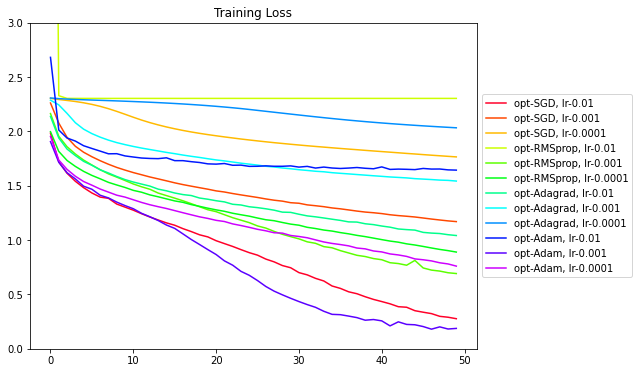

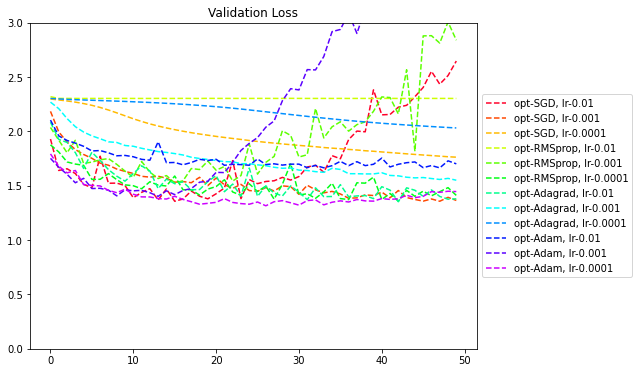

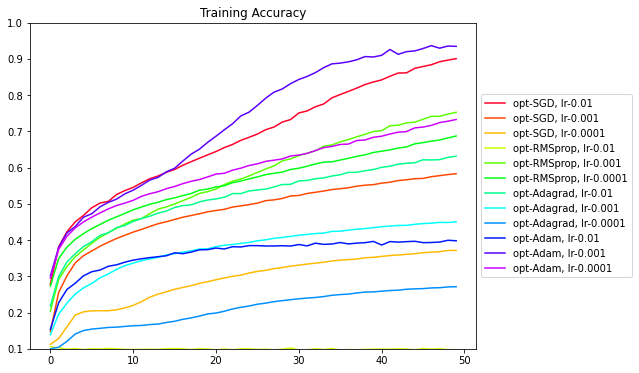

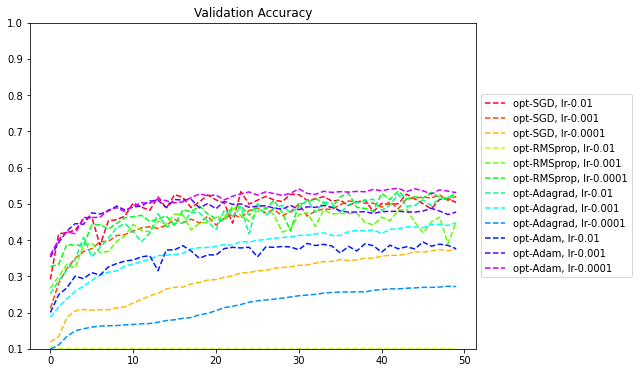

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])), results[cond]['train-loss'], 
             '-', label=cond, color=color_bar[i])
plt.title("Training Loss")
plt.ylim((0, 3))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['valid-loss'])), results[cond]['valid-loss'], 
             '--', label=cond, color=color_bar[i])
plt.title("Validation Loss")
plt.ylim((0, 3))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])), results[cond]['train-acc'], 
             '-', label=cond, color=color_bar[i])
plt.title("Training Accuracy")
plt.ylim((0.1, 1))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['valid-acc'])), results[cond]['valid-acc'], 
             '--', label=cond, color=color_bar[i])
plt.title("Validation Accuracy")
plt.ylim((0.1, 1))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()